In [5]:
#importing my libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os


In [6]:
import cv2

In [7]:
#####dowload dataset
!kaggle datasets download -d alaminbhuyan/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/alaminbhuyan/breast-histopathology-images
License(s): unknown
100% 928M/929M [00:38<00:00, 24.7MB/s]
100% 929M/929M [00:38<00:00, 25.4MB/s]


In [41]:
import zipfile
######
zip_file_path = 'breast-histopathology-images.zip'
extraction_dir = 'breast-histopathology-images'

#########
os.makedirs(extraction_dir, exist_ok=True)

#####Extracting file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

####extraction verification
extracted_files = os.listdir(extraction_dir)
print(extracted_files)


['IDC_regular_ps50_idx5']


In [9]:
IDC_Neg = "/content/breast-histopathology-images/IDC_regular_ps50_idx5/negative_IDC"
IDC_pos = "/content/breast-histopathology-images/IDC_regular_ps50_idx5/positive_IDC"

In [10]:
#### function to check number of images in each folder
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])

#####
count_images(IDC_Neg)

78786

In [11]:
count_images(IDC_pos)

78786

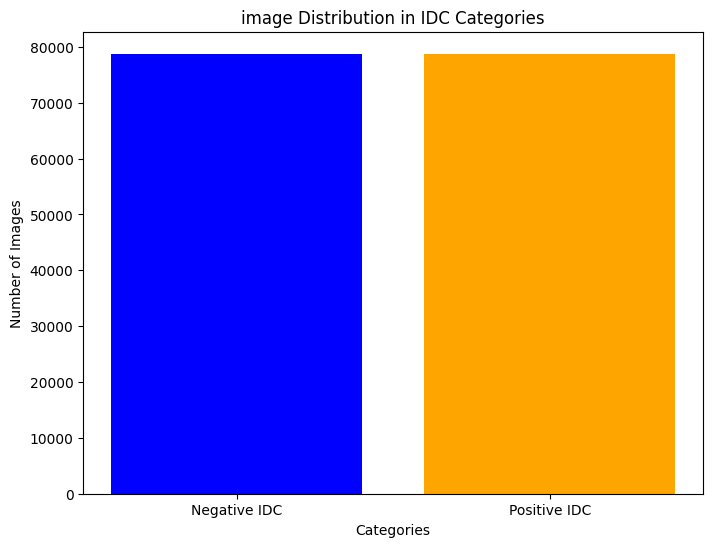

In [12]:
num_neg = len(os.listdir(IDC_Neg))
num_pos = len(os.listdir(IDC_pos))

##### data distribution
categories = ['Negative IDC', 'Positive IDC']
counts = [num_neg, num_pos]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'orange'])
plt.title('image Distribution in IDC Categories')
plt.ylabel('Number of Images')
plt.xlabel('Categories')
plt.show()

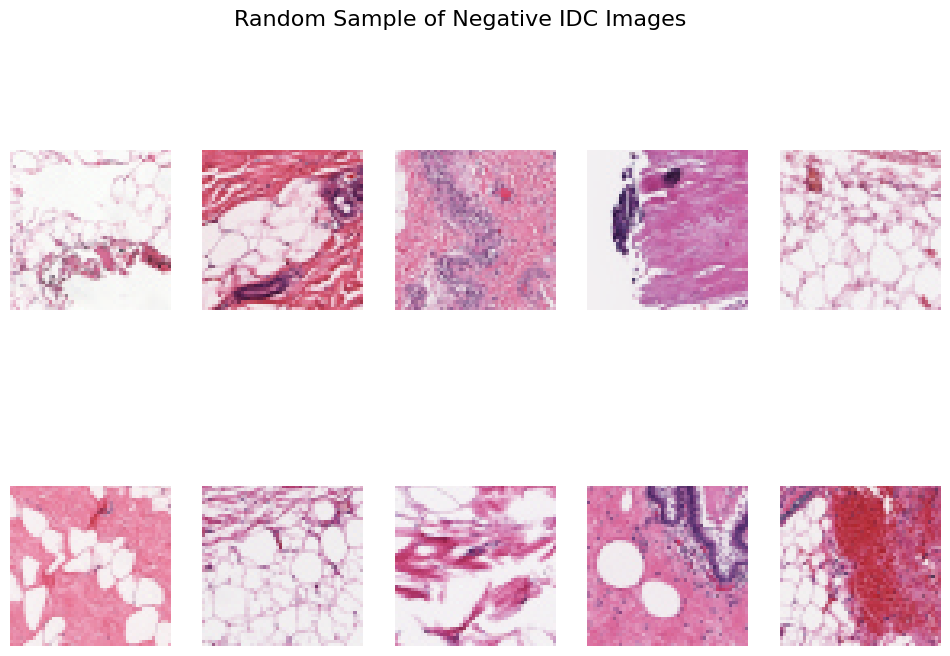

In [13]:
#### image data inspection#
import random
selected_Neg = random.sample(os.listdir(IDC_Neg), 10)


plt.figure(figsize=(12, 8))
for i, file in enumerate(selected_Neg):
    img_path = os.path.join(IDC_Neg, file)
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Random Sample of Negative IDC Images", fontsize=16)
plt.show()

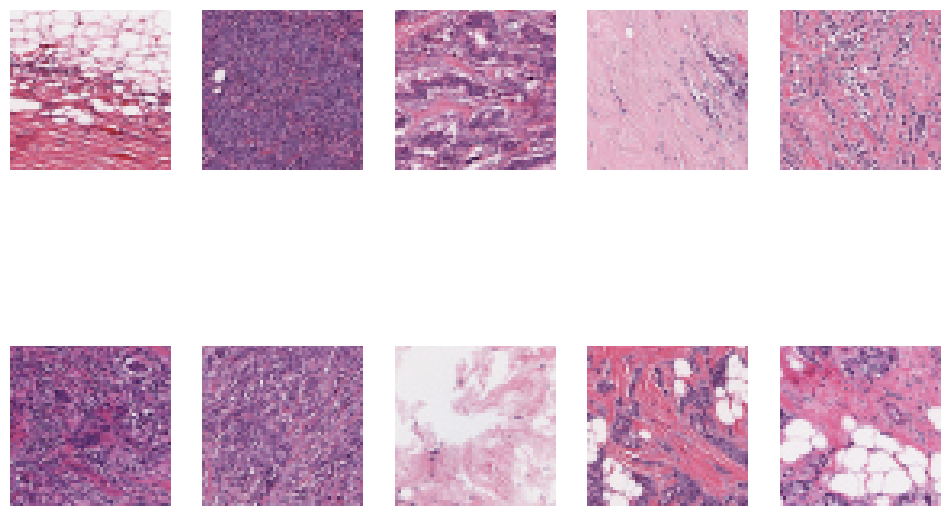

In [14]:
selected_pos = random.sample(os.listdir(IDC_pos), 10)

plt.figure(figsize=(12, 8))
for i, file in enumerate(selected_pos):
  imgs_path = os.path.join(IDC_pos, file)
  imgs= Image.open(imgs_path)
  plt.subplot(2, 5, i + 1)
  plt.imshow(imgs)
  plt.axis('off')

In [15]:
#####check dimension and color channel
def check_image_properties(directory, sample_size=5):
    files = os.listdir(directory)[:sample_size]
    for file in files:
        img_path = os.path.join(directory, file)
        with Image.open(img_path) as img:
            dimensions = img.size
            color_mode = img.mode
            channels = 1 if color_mode == 'L' else 3
            print(f'{file}: Dimensions={dimensions}, Channels={channels}')

### Confrim dimesion
print("Negative IDC Image Properties:")
check_image_properties(IDC_Neg)

print("\nPositive IDC Image Properties:")
check_image_properties(IDC_pos)

Negative IDC Image Properties:
10273_idx5_x1001_y1901_class0.png: Dimensions=(50, 50), Channels=3
12823_idx5_x951_y2151_class0.png: Dimensions=(50, 50), Channels=3
12883_idx5_x2251_y201_class0.png: Dimensions=(50, 50), Channels=3
10259_idx5_x1651_y601_class0.png: Dimensions=(50, 50), Channels=3
12906_idx5_x1551_y2451_class0.png: Dimensions=(50, 50), Channels=3

Positive IDC Image Properties:
9077_idx5_x2201_y1351_class1.png: Dimensions=(50, 50), Channels=3
10276_idx5_x551_y301_class1.png: Dimensions=(50, 50), Channels=3
9077_idx5_x1151_y851_class1.png: Dimensions=(50, 50), Channels=3
9077_idx5_x401_y1451_class1.png: Dimensions=(50, 50), Channels=3
10303_idx5_x1301_y1351_class1.png: Dimensions=(50, 50), Channels=3


In [16]:
####spliting my data to Testing and Training data
from sklearn.model_selection import train_test_split


In [17]:
neg_files = [os.path.join(IDC_Neg, f) for f in os.listdir(IDC_Neg)]
pos_files = [os.path.join(IDC_pos, f) for f in os.listdir(IDC_pos)]

In [18]:
####labeling
neg_labels = [0] * len(neg_files)
pos_labels = [1] * len(pos_files)

In [19]:
all_files = neg_files + pos_files   ####this is our feature X
all_labels = neg_labels + pos_labels #### this is our target y

In [20]:
X_train, X_test, y_train, y_test = train_test_split(all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

In [21]:
len(X_train) ###### number of traininf sample

126057

In [22]:
len(y_train)

126057

In [24]:
##### data processing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
class HistoDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [26]:
train_dataset = HistoDataset(file_paths=X_train, labels=y_train, transform=transform)
test_dataset = HistoDataset(file_paths=X_test, labels=y_test, transform=transform)

####DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [27]:
from torchvision import models

In [28]:
model = models.resnet18(pretrained=True)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

#####
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

####

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def train_model(model, train_loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Training model###
train_model(model, train_loader, criterion, optimizer)

Epoch [1/3], Loss: 0.3291
Epoch [2/3], Loss: 0.2859
Epoch [3/3], Loss: 0.2656


In [34]:
test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 89.95%


In [37]:
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


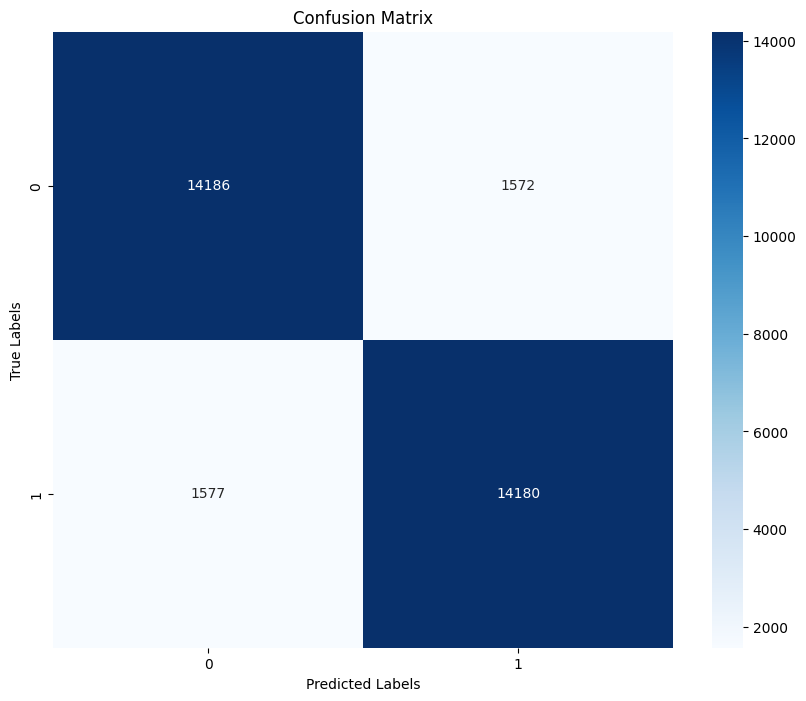

In [38]:
#####checking for accuracy
from sklearn.metrics import confusion_matrix
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
torch.save(model.state_dict(), 'cancerHistopath.pth')
print("Model saved as 'model_state_dict.pth'")

Model saved as 'model_state_dict.pth'
